In [1]:
!pip install conllu
!pip install transformers-interpret

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#fix paths 
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath("../src"))

In [16]:
# imports
from sklearn.model_selection import train_test_split as split
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers_interpret import SequenceClassificationExplainer
from collections import defaultdict
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer
from transformers import AutoModelForSequenceClassification, DistilBertConfig

# custom imports
from data_util import load_data
from dbert import extract_data, encode_data, dataloader, train_bert, plot_metrics, test_bert

#Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Data import

In [3]:
# load the data
path = "../data/dataset.conllu"
#path= "/content/drive/MyDrive/06_TUWien/09_NLP/data/dataset.conllu"
headlines = load_data(path)

#train test validation split
SEED = 42
tr_data, other_data = split(headlines, test_size=0.3, random_state=SEED)
val_data, ts_data = split(other_data, test_size=0.5, random_state=SEED)
print(f"Number of headlines for training, validation, and test is {len(tr_data)}, {len(val_data)}, and {len(ts_data)} resp.")

Number of headlines for training, validation, and test is 20033, 4293, and 4293 resp.


In [4]:
#Get texts and labels from the data
tr_texts, tr_labels = extract_data(tr_data)
val_texts, val_labels = extract_data(val_data)
ts_texts, ts_labels = extract_data(ts_data)

#### Data prep

In [5]:
# Initialize the BERT tokenizer
pretrained_model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name)

In [6]:
# Tokenize data
tr_tokens, tr_atention = encode_data(tr_texts, tokenizer)
val_tokens, val_atention = encode_data(val_texts, tokenizer)
ts_tokens, ts_atention = encode_data(ts_texts, tokenizer)

In [7]:
# Prepaire data for the model
train = dataloader(tr_tokens, tr_atention, tr_labels, tr_texts, batch_size=8, isTrain = True)
validation = dataloader(val_tokens, val_atention, val_labels, val_texts, batch_size=8)
test = dataloader(ts_tokens, ts_atention, ts_labels, ts_texts, batch_size=8)

#### Model setup

In [8]:
# Load the DistilBERT model's configuration
config = DistilBertConfig.from_pretrained('distilbert-base-uncased')

# Labels
id2label = {0: "not_sarcastic", 1: "sarcastic"}
label2id = {"not_sarcastic": 0, "sarcastic": 1}

# Modify the dropout rates (increase them as needed)
config.attention_probs_dropout_prob = 0.25  # Default is 0.1
config.hidden_dropout_prob = 0.25  # Default is 0.1
config.num_labels = 2
config.id2label = id2label
config.label2id = label2id


model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    config=config
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Train DistilBERT Model

In [9]:
# We only want to finetune the classification layer on top of BERT
for p in model.base_model.parameters():
    p.requires_grad = False


for p in model.classifier.parameters():
    print(p.requires_grad)  # Check trainable status

True
True


In [18]:
from tqdm import tqdm  # Standard tqdm for scripts
from tqdm.notebook import tqdm as notebook_tqdm

best_acc, val_loss, train_loss, val_acc, train_acc = train_bert(
    model=model,
    trainloader=train,
    validationloader=validation,
    device=device,
    epochs=10,
    patience=5
)
print(f"Best Validation Accuracy: {best_acc:.4f}")

Starting training for 10 epochs with early stopping (patience=5).

Epoch 1/10


TypeError: 'module' object is not callable

In [ ]:
# Train vs validation metrics
plot_metrics(val_loss, train_loss, val_acc, train_acc)

#### Misclass analysis - quantitative

In [ ]:
model.load_state_dict(torch.load("/content/best_model.pth"))
model.to(device)
test_metrics = test_bert(model, test, device)

In [19]:
#Store predictions on the test set & misclass cases into df
df = test_metrics["df"]

mismatched_df = df[df['True Label'] != df['Predicted Label']]
mismatched_df

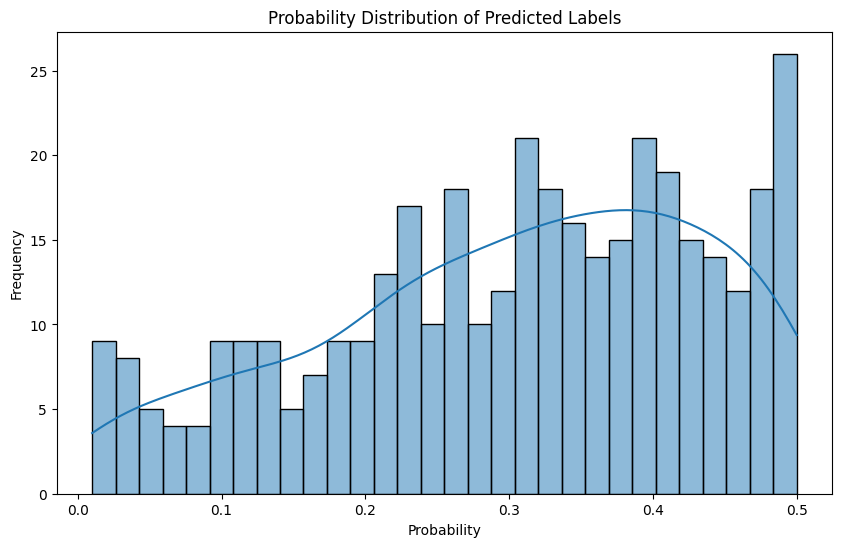

In [21]:
# Create the probability distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(mismatched_df[mismatched_df['True Label']== 1.0]['Probability'], bins = 30, kde=True)
plt.title('Probability Distribution of Incorrectly Predicted Labels = 1')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

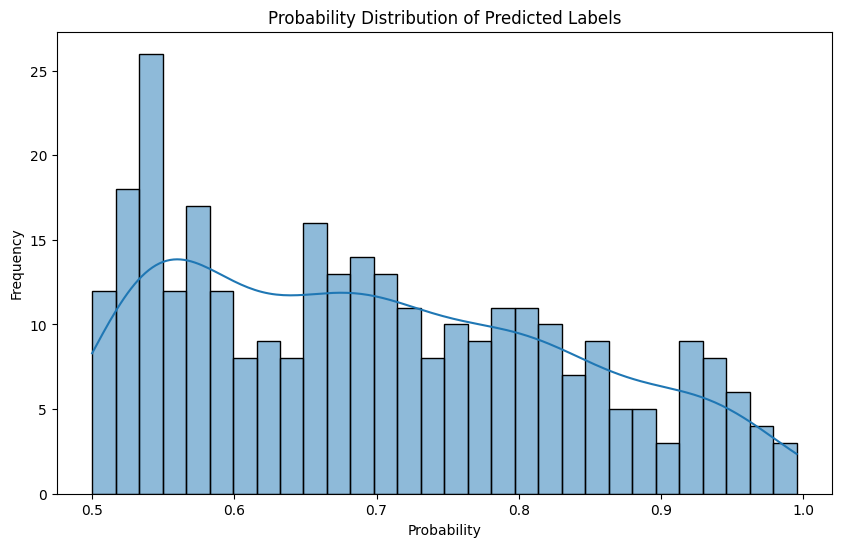

In [22]:
# Create the probability distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(mismatched_df[mismatched_df['True Label']== 0]['Probability'], bins = 30, kde=True)
plt.title('Probability Distribution of Incorrectly Predicted Labels = 0')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

Model is not confident near the borders

In [23]:
target_names = target_names = ['Not Sarcastic', 'Sarcastic']
print(classification_report(df["True Label"], df["Predicted Label"], target_names = target_names))

               precision    recall  f1-score   support

Not Sarcastic       0.84      0.86      0.85      2233
    Sarcastic       0.85      0.82      0.83      2055

     accuracy                           0.84      4288
    macro avg       0.84      0.84      0.84      4288
 weighted avg       0.84      0.84      0.84      4288



#### Misclass - tokens

In [24]:
binary_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)

In [25]:
def interpret_sentence(sentence):
  word_attributions = binary_explainer(sentence)
  return binary_explainer.visualize()

misclass_sentences = list(mismatched_df["Sentences"])
predicted_labels = list(mismatched_df["Predicted Label"])

for sentence in range(10):
    print(f"Sentence: {misclass_sentences[sentence]}")
    print(f"Predicted Label: {predicted_labels[sentence]}")
    interpret_sentence(misclass_sentences[sentence])

Sentence: study owning a boat not worth it
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.67),not_sarcastic,0.86,[CLS] study owning a boat not worth it [SEP]


Sentence: gay conversion therapists claim most patients fully straight by the time they commit suicide
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.65),not_sarcastic,2.13,[CLS] gay conversion therapist ##s claim most patients fully straight by the time they commit suicide [SEP]


Sentence: repopulation of africa begins
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.55),not_sarcastic,0.30,[CLS] rep ##op ##ulation of africa begins [SEP]


Sentence: white terror demands white action what allies need to do right now for charlottesville
Predicted Label: 1.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.67),sarcastic,-1.33,[CLS] white terror demands white action what allies need to do right now for charlotte ##sville [SEP]


Sentence: surge soda is back
Predicted Label: 1.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.68),sarcastic,0.58,[CLS] surge soda is back [SEP]


Sentence: supreme court upholds bill of rights in 54 decision
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.78),not_sarcastic,1.73,[CLS] supreme court uphold ##s bill of rights in 54 decision [SEP]


Sentence: interview with louise munson playwright of luigi
Predicted Label: 1.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.55),sarcastic,-0.44,[CLS] interview with louise mu ##nson playwright of luigi [SEP]


Sentence: exxonmobil swears its going to start taxes early this year
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.53),not_sarcastic,1.54,[CLS] ex ##xon ##mo ##bil swear ##s its going to start taxes early this year [SEP]


Sentence: biden calls dibs on qaddafis clothes
Predicted Label: 0.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.72),not_sarcastic,1.35,[CLS] bid ##en calls di ##bs on q ##ad ##da ##fi ##s clothes [SEP]


Sentence: cupid cop gave out roses cards on valentines day instead of tickets
Predicted Label: 1.0


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.66),sarcastic,-0.75,[CLS] cup ##id cop gave out roses cards on valentine ##s day instead of tickets [SEP]


In [26]:
# Initialize dictionaries to store positive and negative counts for each token
positive_token_counts = defaultdict(int)
negative_token_counts = defaultdict(int)

# Define a function to interpret a sentence and aggregate scores
def interpret_sentence_and_aggregate(sentence ):
    word_attributions = binary_explainer(sentence)

    # Extract tokens and scores from word_attributions
    for token, score in word_attributions:  # Assuming word_attributions is a list of (token, score)
        if score > 0:
            positive_token_counts[token] += 1
        elif score < 0:
            negative_token_counts[token] += 1

# Iterate over sentences
misclass_sentences = list(mismatched_df["Sentences"])
predicted_labels = list(mismatched_df["Predicted Label"])

for sentence in misclass_sentences:
    interpret_sentence_and_aggregate(sentence)

In [27]:
# Calculate total counts for positive and negative tokens
total_positive_tokens = sum(positive_token_counts.values())
total_negative_tokens = sum(negative_token_counts.values())

# Calculate percentage contributions
positive_token_percentages = {
    token: (count / total_positive_tokens) * 100 for token, count in positive_token_counts.items()
}
negative_token_percentages = {
    token: (count / total_negative_tokens) * 100 for token, count in negative_token_counts.items()
}

# Sort and get top 10 tokens for positive and negative percentages
top_positive_tokens = sorted(positive_token_percentages.items(), key=lambda x: x[1], reverse=True)[:20]
top_negative_tokens = sorted(negative_token_percentages.items(), key=lambda x: x[1], reverse=True)[:20]

# Print the top 10 results with percentages
print("Top 10 tokens more often positive (as percentage of total):")
for token, percentage in top_positive_tokens:
    print(f"{token}: {percentage:.2f}%")

print("\nTop 10 tokens more often negative (as percentage of total):")
for token, percentage in top_negative_tokens:
    print(f"{token}: {percentage:.2f}%")


Top 10 tokens more often positive (as percentage of total):
to: 2.53%
##s: 2.18%
of: 1.78%
in: 1.17%
for: 1.07%
the: 0.92%
on: 0.65%
a: 0.59%
trump: 0.59%
you: 0.54%
at: 0.52%
by: 0.44%
after: 0.44%
from: 0.44%
who: 0.38%
new: 0.36%
into: 0.36%
man: 0.36%
your: 0.36%
with: 0.34%

Top 10 tokens more often negative (as percentage of total):
to: 3.54%
##s: 2.24%
of: 2.15%
in: 1.74%
for: 1.39%
on: 0.98%
a: 0.92%
the: 0.85%
new: 0.76%
with: 0.70%
and: 0.60%
by: 0.54%
after: 0.51%
trump: 0.47%
##t: 0.47%
at: 0.41%
this: 0.35%
up: 0.35%
from: 0.32%
has: 0.32%
